In [1]:
x = "foo"
print(x)

foo


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
DIR = Path(".").absolute()
sys.path.append(str(DIR.parent))
print(sys.path[0])

OUT = DIR / "data-tuning"
list(OUT.iterdir())

/home/sieverts/miniconda3/envs/finetune/lib/python311.zip


[PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning/search-sgd.pkl'),
 PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning/search-adadamp.pkl'),
 PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning/search-adagrad.pkl'),
 PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning/search-geodamp.pkl'),
 PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning/search-gd.pkl'),
 PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning/search-radadamp.pkl'),
 PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning/search-adadelta.pkl'),
 PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning/_')]

In [4]:
from single import Wrapper, MLP
import pickle

damper = "sgd"
with open(OUT / f"search-{damper}.pkl", "rb") as f:
    search = pickle.load(f)

# [x for x in dir(search) if x[0] != "_"]

In [5]:
# x.best_params_
# search.best_params_
import pandas as pd
df = pd.DataFrame(search.cv_results_)
df = df.sort_values(by="mean_test_score", ascending=False)
print(df.columns)
df.drop(columns=["params"]).head(n=5)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_damper', 'param_dwell', 'param_initial_batch_size', 'param_lr',
       'param_max_batch_size', 'param_momentum', 'param_nesterov',
       'param_weight_decay', 'params', 'split0_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_damper,param_dwell,param_initial_batch_size,param_lr,param_max_batch_size,param_momentum,param_nesterov,param_weight_decay,split0_test_score,mean_test_score,std_test_score,rank_test_score
42,94.843041,0.0,0.000020,0.0,sgd,5,16,0.000171,None,0.959372,True,1.004263e-07,-1.317341,-1.317341,0.0,1
36,97.521162,0.0,0.000013,0.0,sgd,10,16,0.000093,512,0.984902,True,3.392699e-05,-1.367655,-1.367655,0.0,2
23,98.275134,0.0,0.000014,0.0,sgd,1,16,0.000082,8192,0.972702,True,1.656247e-07,-1.397755,-1.397755,0.0,3
19,41.274275,0.0,0.000021,0.0,sgd,5,192,0.000797,256,0.990544,True,3.608493e-08,-1.407651,-1.407651,0.0,4
1,37.260130,0.0,0.000022,0.0,sgd,5,224,0.000216,4096,0.997417,True,1.208754e-08,-1.410775,-1.410775,0.0,5


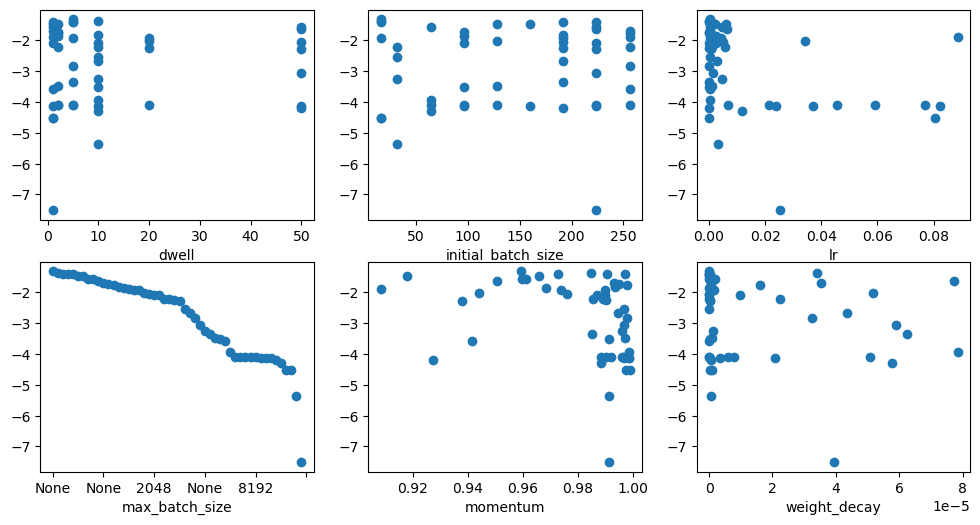

In [6]:
params = [c for c in df.columns if "param_" in c and ("damper" not in c and "nesterov" not in c)]
import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(4 * w, 2 * w))
for ax, param in zip(axs.flatten(), params):
    ax = df.plot(x=param, y="mean_test_score", ax=ax, style="o")
    ax.legend_.remove()
    ax.set_xlabel(param.replace("param_", ""))

In [7]:
import pickle
import random
import torch
import train

model_f = random.choice(list(OUT.glob("model-*")))
ident = model_f.name.split("-")[-1][:-3]
damper = model_f.name.split("-")[-2]

with open(OUT / f"stats-{damper}-{ident}.pkl", "rb") as f:
    d = pickle.load(f)
assert {
    "data_test", "data_train", "test_set", "params", "ident_", "stats_"
}.issubset(set(d.keys()))

data_train = d["data_train"]
data_test = d["data_test"]
test_set = d["test_set"]

model = train.Autoencoder(32, 100, num_input_channels=3)
model.load_state_dict(torch.load(model_f, weights_only=True))#, map_location=torch.device("cpu"))

IndexError: Cannot choose from an empty sequence

In [49]:
n_params = sum([x.numel() for x in model.parameters()])
print(n_params / 1e3)

410.855


In [50]:
import pandas as pd
df_train = pd.DataFrame(data_train)
df = pd.DataFrame(data_test)
df.head()

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,test_prefix,_epochs,_num_examples,_train_time,damping,_step_time,time,step_time,lr_,batch_size_
0,1.725050e+09,192,2048,0.01,1,3,0.000000,True,0.000348,False,...,test,1.0,58752.0,24.795258,NaN,NaN,NaN,NaN,NaN,NaN
1,1.725050e+09,192,2048,0.01,1,3,1.002508,True,0.000348,False,...,test,1.0,58752.0,22.437713,192.0,0.073229,1.725050e+09,0.073295,0.000348,192.0
2,1.725050e+09,192,2048,0.01,1,3,2.005017,True,0.000348,False,...,test,NaN,NaN,NaN,192.0,0.071437,1.725050e+09,0.071502,0.000348,192.0


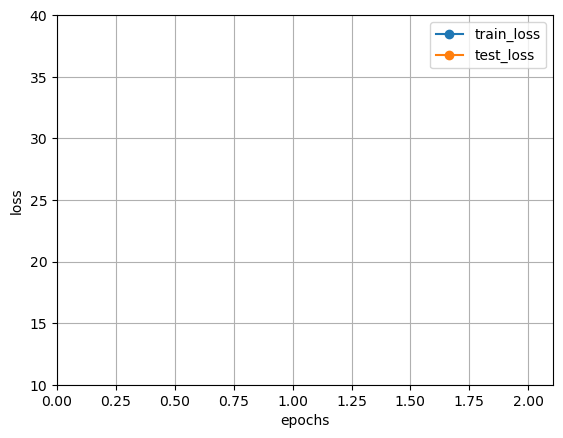

In [51]:
import matplotlib.pyplot as plt
ax = df.plot(x="epochs", y=["train_loss", "test_loss"], style="o-")
ax.set_ylim(10, 40)
ax.grid()
ax.set_ylabel("loss")
ax.set_xlim(0, None)
plt.savefig("loss.png", dpi=300, bbox_inches="tight")
# ax.set_yscale("log")

(0.0, 40.0)

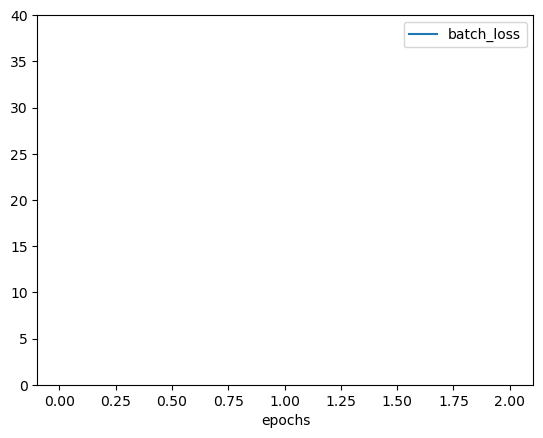

In [52]:
ax = df_train.plot(x="epochs", y="batch_loss")
ax.set_ylim(0, 40)
# ax.set_yscale("log")

In [53]:
def itransform(x, bounds=(-1, 1)):
    width = bounds[1] - bounds[0]
    offset = bounds[0]
    return (x - offset) / width

(32, 32, 3)
(32, 32, 3)
0.54509807 0.09019607
0.48877484 0.4492343
(32, 32, 3)
(32, 32, 3)
0.7254902 0.25882354
0.48877487 0.44923463
(32, 32, 3)
(32, 32, 3)
0.47450984 0.02352941
0.4887749 0.44923416
(32, 32, 3)
(32, 32, 3)
0.54901963 0.16862744
0.48877484 0.4492345
(32, 32, 3)
(32, 32, 3)
0.7411765 0.07843137
0.4887747 0.4492345


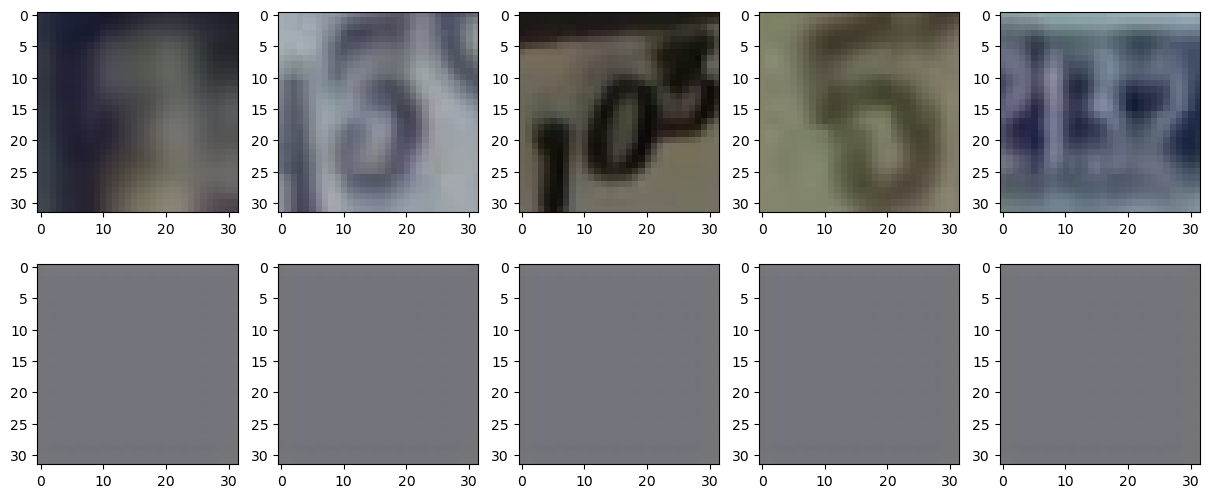

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import torch

w = 3
n_imgs = 5

model = model.to("cuda")
idx = np.random.choice(len(test_set), replace=False, size=n_imgs).tolist()
# idx = [2*i + 1 for i in range(n_imgs)]
imgs = [test_set[i][0] for i in idx]
imgs_in = torch.stack(imgs).to("cuda")
out = model(imgs_in).detach().cpu().numpy()

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(n_imgs * w, 2 * w))
for i in range(n_imgs):
    img = imgs[i] # [imgs[i][0], imgs[i][1], imgs[i][2]]
    oimg = out[i]
    img2 = np.stack((img[0, :, :], img[1, :, :], img[2, :, :]), axis=-1)
    out2 = np.stack((oimg[0], oimg[1], oimg[2]), axis=-1)
    img2 = itransform(img2)
    out2 = itransform(out2)
    print(img2.shape)
    print(out2.shape)
    print(img2.max(), img2.min())
    print(out2.max(), out2.min())
    axs[0][i].imshow(img2)
    axs[1][i].imshow(out2)

In [29]:
fig.savefig("./example.png", dpi=300, bbox_inches="tight")

In [34]:
!open .